To-do:
* Update table of contents
* Add summary
* Edit conclusion

# Credit Card Fraud Detection

***By Joe Corliss***

## Table of Contents

1. [Check the Data](#1)
2. [Pre-processing](#2)
3. [Predictive Modeling](#3)
    1. [Linear Classification with Stochastic Gradient Descent (SGD)](#3.1)
    2. [Random Forest Classifier](#3.2)

# Introduction

[The Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) - The data source on Kaggle

[Kaggle Notebook](https://www.kaggle.com/pileatedperch/linear-svc-random-forest-mcc-0-77-0-88) - A version of this notebook hosted on Kaggle

[GitHub Repository](https://github.com/jgcorliss/credit-card-fraud) - This project on GitHub

(Summary)

# Basic Metadata
<a id='1'></a>

Import basic libraries:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read in the data to a pandas dataframe.

In [2]:
df = pd.read_csv('creditcard.csv')

Check basic metadata.

In [3]:
df.shape

(284807, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Are there any incomplete variables?

In [5]:
def incomplete_cols(df):
    """
    Returns a list of incomplete columns in df and their completion percentage.
    
    Input: pandas DataFrame
    Return: pandas Series
    """
    cmp = df.notnull().mean()
    cmp = cmp.loc[cmp<1]
    dec = np.int64(np.ceil(np.log10(df.shape[0]))) - 2 # Number of decimal places based on no. of samples
    return cmp.apply(lambda val: str(np.round(100*val, decimals=dec))+'%')

In [6]:
incomplete_cols(df)

Series([], dtype: float64)

There are no variables with missing values!

Let's randomly sample some observations (credit card transactions).

In [7]:
df.sample(5)

Time        V1        V2        V3        V4        V5        V6  \
231785  146926.0 -0.509248  0.481136  0.637113 -0.490650  1.450776  0.471037   
253689  156362.0 -0.342363  1.189522 -0.893358 -0.597363  0.414975 -0.835531   
155791  106391.0 -0.605921  0.938154  2.359743 -0.142475  0.115729 -0.222119   
64338    51114.0  1.235580  0.202417  0.162739  0.512794 -0.267806 -0.590883   
117682   74764.0  1.403315 -0.316926 -0.219757 -0.708948 -0.420327 -0.922302   

              V7        V8        V9       V10       V11       V12       V13  \
231785  0.637260  0.218653 -0.460239 -0.733158 -0.276587  0.441338  0.307585   
253689  0.734197  0.270017 -0.329103 -1.102109  0.513552 -0.010504 -0.885861   
155791  0.588859 -0.320029  1.516950 -1.053642  0.389093 -2.371554  2.070724   
64338  -0.109939  0.036919 -0.011160 -0.075787  1.120934  0.135514 -1.079398   
117682 -0.083840 -0.288491 -1.201280  0.633033  0.042737 -0.374591  0.394879   

             V14       V15       V16       V17       V18       V19       V20  \
231785  0.251165  0.707969 -1.263269  0.655684 -2.084222 -0.548066 -0.073484   
253689 -0.230671 -0.155390  0.698349  0.092059  1.395305 -0.193519 -0.314931   
155791  1.135890  0.610804 -0.361253  0.322022  0.371876  0.469691  0.048273   
64338   0.143754  0.557733  0.830654 -0.302339  0.460117  0.223490 -0.140939   
117682  0.084581  0.642777  0.420698  0.669113 -2.085912  0.274587  0.055083   

             V21       V22       V23       V24       V25       V26       V27  \
231785 -0.093341 -0.152912  0.072736 -1.102167 -0.679389  0.339694  0.137391   
253689  0.345919  0.848080 -0.260746 -0.498915  0.008683 -0.178962 -0.184373   
155791 -0.287465 -0.376511 -0.310317 -0.104510  0.248514 -0.738756 -0.199762   
64338  -0.272191 -0.882590  0.091670 -0.071925  0.186558  0.101597 -0.035676   
117682  0.222132  0.621787 -0.139131  0.137630  0.729859 -0.056810 -0.010737   

             V28  Amount  Class  
231785  0.145859    1.79      0  
253689 -0.025419   42.81      0  
155791 -0.152970   11.27      0  
64338   0.014569    1.78      0  
117682 -0.000518   15.00      0

How balanced are the classes, i.e. how common are fraudulent transactions?

In [8]:
def perc_value_counts(series):
    """
    Returns normalized value counts as percentages, including NA values, sorted by the index.
    
    Input: pandas Series
    Return: pandas Series
    """
    dec = np.int64(np.ceil(np.log10(len(series)))) - 2 # Number of decimal places based on no. of samples
    percs = series.value_counts(normalize=True, dropna=False).apply(lambda val: str(np.round(100*val, decimals=dec))+'%')
    return percs.sort_index()

In [9]:
perc_value_counts(df['Class'])

0    99.8273%
1     0.1727%
Name: Class, dtype: object

**Only 0.17% of transactions are fraudulent.**

# Train/Test Split

Before we begin preprocessing, we split off a test data set.

Split the data into features and response variable:

In [10]:
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class'] # Response variable
df = None

We perform a split with a **test size of 20%**. We also **stratify** the split on the response variable, which is very important to do because there are so few fraudulent transactions.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
random_state = 1 # Just to make the results deterministic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
X = None
y = None

In [13]:
# Prevent view warnings
X_train.is_copy = False
X_test.is_copy = False

# Exploratory Data Analysis

We conduct EDA only on the training set, and leave the test set unknown.

## Time

Look at summary statistics:

In [14]:
X_train['Time'].describe()

count    227845.000000
mean      94707.617670
std       47523.204111
min           0.000000
25%       54086.000000
50%       84609.000000
75%      139261.000000
max      172792.000000
Name: Time, dtype: float64

What is the time of the last transaction, in days?

In [15]:
X_train['Time'].max()/(3600*24)

1.9999074074074075

So the transactions indeed occur over a two-day period.

Histogram of transaction times:

Text(0.5,1,'Transaction Times')

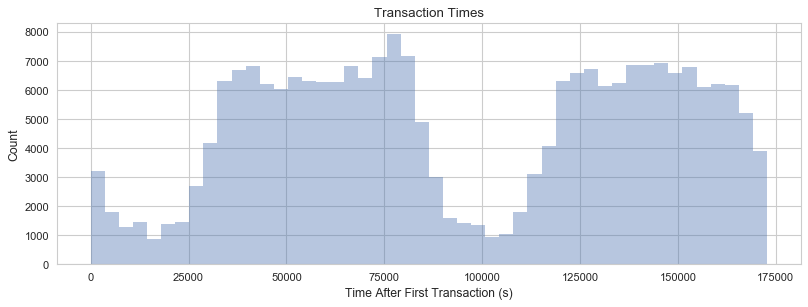

In [16]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Time'], bins=48, kde=False)
plt.xlabel('Time After First Transaction (s)')
plt.ylabel('Count')
plt.title('Transaction Times')

It looks like there are two lulls in credit card transactions during nighttime on each day.

## Amount

Summary statistics:

In [17]:
X_train['Amount'].describe()

count    227845.000000
mean         88.709296
std         250.026305
min           0.000000
25%           5.550000
50%          22.000000
75%          77.890000
max       25691.160000
Name: Amount, dtype: float64

Comparing the different quantiles, it looks like the amounts are very right-skewed. We'll verify this, starting with a histogram of the transaction amounts:

Text(0.5,1,'Transaction Amounts')

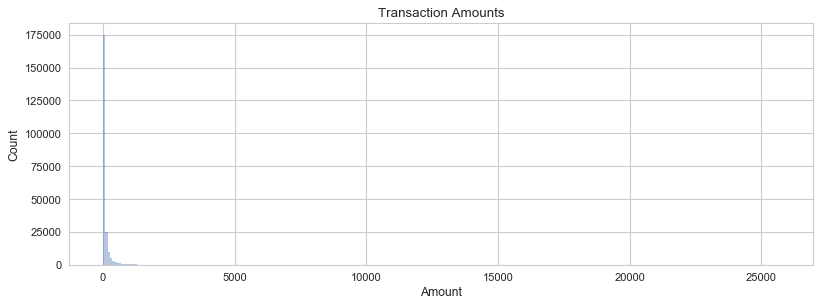

In [18]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Amount'], bins=300, kde=False)
plt.ylabel('Count')
plt.title('Transaction Amounts')

The histogram is hard to read due to some outliers we can't see. A boxplot will show the outliers:

Text(0.5,1,'Transaction Amounts')

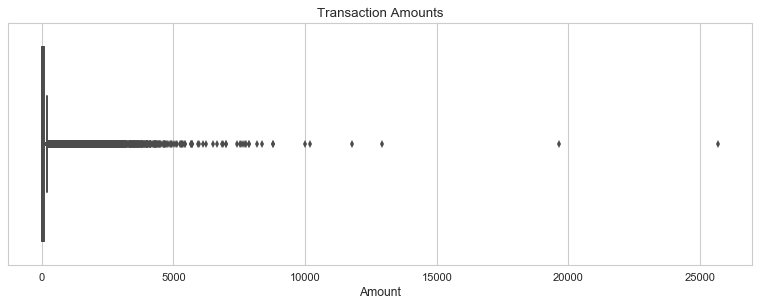

In [19]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['Amount'])
plt.title('Transaction Amounts')

We can see there are no outliers on the left and many outliers on the right. So the amounts certainly seem right-skewed. We can calculate the skewness to be sure:

In [20]:
X_train['Amount'].skew()

16.910303546516744

That's a strong right skew. Let's use a **power transform** to bring the transaction amounts closer to a normal distribution. We'll use the [Box-Cox transform in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html), but some of the amounts are zero (min = 0 above), so we need to shift the amounts first to make them positive. We'll shift by a very small amount, just $10^{-9}$.

In [21]:
X_train.loc[:,'Amount'] = X_train['Amount'] + 1e-9 # Shift all amounts by 1e-9

Perform the Box-Cox transform:

In [22]:
X_train.loc[:,'Amount'], maxlog, (min_ci, max_ci) = sp.stats.boxcox(X_train['Amount'], alpha=0.01)

The maximum likelihood estimate of $\lambda$ in the Box-Cox transform:

In [23]:
maxlog

0.13436569191158662

The 99% confidence interval for $\lambda$:

In [24]:
(min_ci, max_ci)

(0.13291390124729957, 0.1358266545085391)

Plot the newly transformed amounts:

Text(0.5,1,'Transaction Amounts (Box-Cox Transformed)')

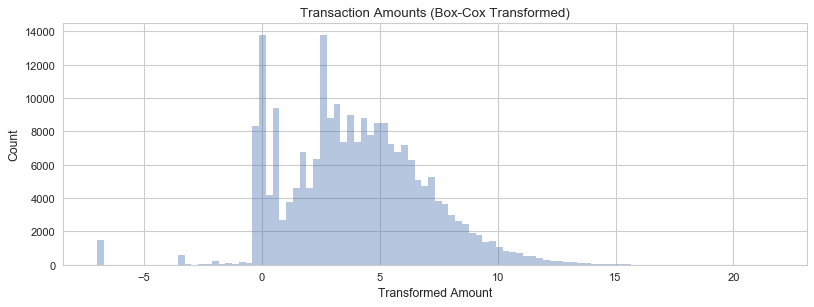

In [57]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['Amount'], bins=100, kde=False)
plt.xlabel('Transformed Amount')
plt.ylabel('Count')
plt.title('Transaction Amounts (Box-Cox Transformed)')

The distribution appears to be bimodal, suggesting a divide between "small" and "large" purchases.

Descriptive stats of the transformed amounts:

In [26]:
X_train['Amount'].describe()

count    227845.000000
mean          3.985515
std           2.972505
min          -6.982733
25%           1.927181
50%           3.831861
75%           5.919328
max          21.680566
Name: Amount, dtype: float64

Much nicer! We'll fully standardize the data later (transform to zero mean and unit variance). But first we need to perform Box-Cox on the test data amounts as well, using the $\lambda$ value estimated on the training data.

In [27]:
X_test.loc[:,'Amount'] = X_test['Amount'] + 1e-9 # Shift all amounts by 1e-9

In [28]:
X_test.loc[:,'Amount'] = sp.stats.boxcox(X_test['Amount'], lmbda=maxlog)

## Time vs. Amount

Is there a relationship between the transaction amounts and the time of day? Let's explore this question with a joint histogram using hexagonal bins. For this plot, we convert each transaction time to the hour of the day on which it occurred.

Text(0.5,1,'Transaction Amounts vs. Time of Day')

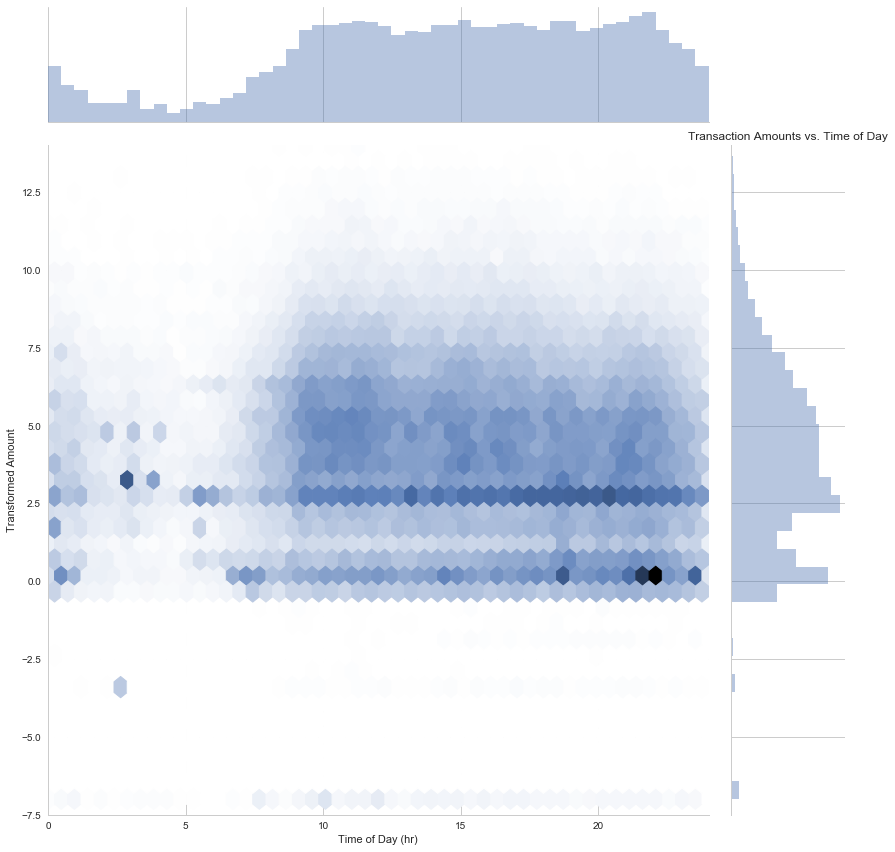

In [58]:
sns.jointplot(X_train['Time'].apply(lambda x: (x % 86400)/3600), X_train['Amount'], kind='hex', stat_func=None, size=12, xlim=(0,24), ylim=(-7.5,14)).set_axis_labels('Time of Day (hr)','Transformed Amount')
plt.title('Transaction Amounts vs. Time of Day')

The transaction amounts appear to be similarly distributed throughout the daytime hours. However, in the earliest hours of the day, around 5-7 AM, amounts around 2.5 are the most common (recall this is a Box-Cox transformed value). Perhaps everyone's buying their morning coffee?

## V1-V28

Let's compare the descriptive stats of the PCA variables `V1-V28`.

In [ ]:
pca_vars = ['V%i' % k for k in range(1,29)]

Full table of descriptive stats:

In [ ]:
X_train[pca_vars].describe()

It's tiresome to interpret this table, so let's make some visualizations. We'll start by plotting the means:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].mean(), color='darkblue')
plt.xlabel('Column')
plt.ylabel('Mean')
plt.title('V1-V28 Means')

All of `V1-V28` have approximately zero mean.

Plot the standard deviations:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].std(), color='darkred')
plt.xlabel('Column')
plt.ylabel('STD')
plt.title('V1-V28 Standard Deviations')

The PCA variables have roughly unit variance, but as low as ~0.3 and as high as ~1.9.

Plot the skewnesses:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].skew(), color='darkgreen')
plt.xlabel('Column')
plt.ylabel('Skewness')
plt.title('V1-V28 Skewnesses')

A few of the PCA variables are significantly skewed. Let's plot a histogram of the particularly skewed variables to see the distribution in detail.

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['V8'], bins=300, kde=False)
plt.ylabel('Count')
plt.title('V8')

The histogram doesn't show us outliers. Let's try a boxplot instead:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['V8'])
plt.title('V8')

The boxplot is also hard to read due to the large number of outliers, which indicates high kurtosis in `V8`. This motivates us to plot the kurtoses of the PCA variables. The kurtosis method employed in pandas is Fisherâ€™s definition, for which the standard normal distribution has kurtosis 0.

Note the log scale in the plot below:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
plt.yscale('log')
sns.barplot(x=pca_vars, y=X_train[pca_vars].kurtosis(), color='darkorange')
plt.xlabel('Column')
plt.ylabel('Kurtosis')
plt.title('V1-V28 Kurtoses')

We've learned that many of the PCA variables are heavy-tailed.

A variable of particular interest is `V28`, which has both the highest skewness and the highest kurtosis among the PCA variables. Let's take a closer look, starting with a histogram:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.distplot(X_train['V28'], bins=500, kde=False)
plt.ylabel('Count')
plt.title('V28')

And a boxplot:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['V28'])
plt.title('V28')

We see a large number of outliers, as suggested by the very high kurtosis:

In [ ]:
X_train['V28'].kurtosis()

Because `V28` is the last PCA variable, it should be the "least important," i.e. it accounts for the least variance in the original data as compared to `V1-V27`. So hopefully the high skewness/kurtosis in `V28` will not cause much difficulty in modeling. As for `V1-V27`, it's harder to say.

The large numbers of outliers in `V1-V28` motivates us to consider robust descriptive statistics. Let's plot the medians:

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].median(), color='darkblue')
plt.xlabel('Column')
plt.ylabel('Median')
plt.title('V1-V28 Medians')

The medians are also roughly zero. Next let's look at the interquartile ranges (IQR)*:

*Pandas does not have a built-in IQR method, but we can use the [`quantile`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.quantile.html) method.

In [ ]:
plt.figure(figsize=(12,4), dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].quantile(0.75) - X_train[pca_vars].quantile(0.25), color='darkred')
plt.xlabel('Column')
plt.ylabel('IQR')
plt.title('V1-V28 IQRs')

The IQRs of `V1-V28` are on a similar scale as the standard deviations.

# Data Standardization

Because the STD and IQR of `V1-V28` are similar in size, it should work fine to standardize the data to zero mean and unit variance. Otherwise, we might consider using [`RobustScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html).

In [59]:
from sklearn.preprocessing import StandardScaler

Fit the scaler only to the training data to avoid test set leakage.

In [60]:
scaler = StandardScaler().fit(X_train)

Scale the data.

In [61]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# Predictive Modeling
<a id='3'></a>

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Linear Classification with Stochastic Gradient Descent (SGD)
<a id='3.1'></a>

The estimator [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) implements multiple linear classifiers with SGD training, which makes learning much faster on large datasets at the cost of accuracy.

In [63]:
from sklearn.linear_model import SGDClassifier

### Train with hyperparameter grid search

The particular linear classifier is chosen with the `loss` hyperparameter. We'll try a linear SVC (`loss = 'hinge'`) and logistic regression (`loss = 'log'`).

Set the hyperparameter grid:

In [ ]:
param_grid = [{'loss': ['hinge'],
               'alpha': [10**k for k in range(-3,4)],
               'class_weight': [None, 'balanced']
              },
              {'loss': ['log'],
               'penalty': ['l1', 'l2'],
               'alpha': [10**k for k in range(-3,3)]
              }]

The grid search will employ [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) with 3 folds for the train/CV splits, by default for [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). We'll use the [Matthews correlation coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) (MCC) as our scoring metric.

In [ ]:
sgdcls_grid = GridSearchCV(estimator=SGDClassifier(max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), n_jobs=-1, verbose=0)

Perform the grid search:

In [ ]:
sgdcls_grid.fit(X_train, y_train)

What are the optimal hyperparameters found in our grid search?

In [ ]:
sgdcls_grid.best_params_

Mean cross-validated MCC score of the best estimator:

In [ ]:
sgdcls_grid.best_score_

This is a fairly good MCC. Let's hope it generalizes to the test set.

### Test set evaluation

Make test set predictions.

In [ ]:
y_pred_sgdcls = sgdcls_grid.predict(X_test)

Calculate evaluation metrics.

In [72]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score

In [70]:
# Display classification evaluation metrics
def classification_eval(y_test, y_pred):
    dec = np.int64(np.ceil(np.log10(len(y_test)))) # Number of decimal places based on no. of samples
    print('Confusion matrix -----------------------'+3*(dec-1)*'-')
    print(confusion_matrix(y_test, y_pred), '\n')
    print('Classification report ------------------'+3*(dec-1)*'-')
    print(classification_report(y_test, y_pred, digits=dec))
    print('Scalar metrics -------------------------'+3*(dec-1)*'-')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

In [ ]:
classification_eval(y_test, y_pred_sgdcls)

Note that the model actually performed slightly *better* on the test set than on the training set, according to the MCC.

## Random Forest Classifier
<a id='3.2'></a>

Next we try a random forest model, implemented in [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [64]:
from sklearn.ensemble import RandomForestClassifier

### Train

The random forest takes much longer to train on this fairly large dataset, so we won't tune the hyperparameters with a grid search. We'll just use default values, except for 100 estimators (the default is 10) and building trees in parallel (`n_jobs = -1`).

In [65]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)

In [66]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Calculate the MCC on the training set:

In [67]:
matthews_corrcoef(y_train, rf.predict(X_train))

1.0

Wow, the random forest model achieves 100% accuracy on the training set. Hopefully it didn't overfit the training data! We should consider trying different `n_estimators` with cross-validation to prevent overfitting.

### Test set evaluation

Make test set predictions.

In [68]:
y_pred_rf = rf.predict(X_test)

Calculate evaluation metrics.

In [73]:
classification_eval(y_test, y_pred_rf)

Confusion matrix -----------------------------------
[[56858     6]
 [   15    83]] 

Classification report ------------------------------
             precision    recall  f1-score   support

          0    0.99974   0.99989   0.99982     56864
          1    0.93258   0.84694   0.88770        98

avg / total    0.99962   0.99963   0.99962     56962

Scalar metrics -------------------------------------
          MCC = 0.88855
Cohen's kappa = 0.88752
     Accuracy = 0.99963


The random forest performed better than the linear SVC, according to the MCC. However, the results may vary significantly for different train/test splits.

### Feature Importances

We can examine the random forest's calculated feature importances: the higher, the more important the feature. The feature importances always add up to 1.

Text(0.5,1,'Random Forest Feature Importances')

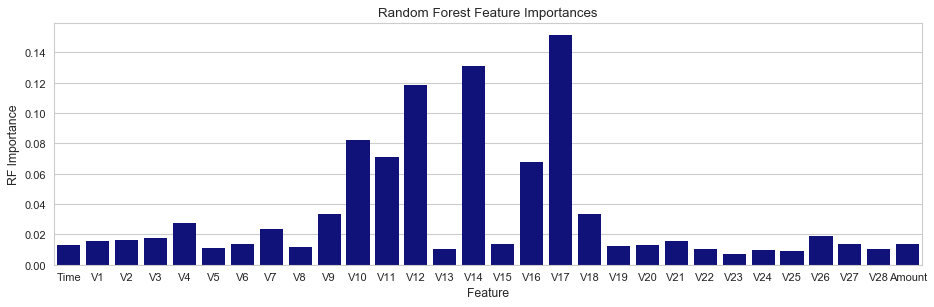

In [75]:
plt.figure(figsize=(14,4), dpi=80)
sns.barplot(x=X_train.columns, y=rf.feature_importances_, color='darkblue')
plt.xlabel('Feature')
plt.ylabel('RF Importance')
plt.title('Random Forest Feature Importances')

It appears that only six or so features---`V10`, `V11`, `V12`, `V14`, `V16`, `V17`---are important in detecting fraud. Unfortunately, because these variables came out of PCA, we cannot interpret their meaning. Moreover, descriptions of the original features (before PCA) are not available.

## Naive Bayes
<a id='3.2'></a>

Next we try Gaussian Naive Bayes, implemented in [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).

In [ ]:
from sklearn.naive_bayes import GaussianNB

### Train

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X_train, y_train)

Calculate the MCC on the training set:

In [ ]:
matthews_corrcoef(y_train, gnb.predict(X_train))

Really poor performance.

### Test set evaluation

In [ ]:
y_pred_gnb = gnb.predict(X_test)

Calculate evaluation metrics:

In [ ]:
classification_eval(y_test, y_pred_gnb)

Also very poor performance, due to a large number of false positives. What might explain the poor performance of Naive Bayes for this problem?

# Conclusion

We were able to accurately predict fraudulent credit card transactions (test set MCC = 0.88) using a random forest model. It may be possible to improve the random forest by optimizing the hyperparameters, given sufficient time/computational power.

We were able to successfully model the data with only minimal preprocessing:
* Power transform (Box-Cox) of the transaction amounts
* Mean and variance normalization of all variables

We also attempted linear classifiers (linear SVC and logistic regression) with stochastic gradient descent training, as well as a Gaussian Naive Bayes model, but these models were not as successful as a random forest. On the test set, the linear SVC achieved MCC = 0.82, and Naive Bayes achieved MCC = 0.23.